Join the crash dataset to the street centerline dataset. 

In [1]:
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from shapely.geometry import Point, LineString

pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth', 200)

In [2]:
denver_crs = 3502
web_crs = 4326

In [3]:
from crash_data_analysis import CrashDataAnalysis
cda = CrashDataAnalysis()
df = cda.crash_dataframe()

In [4]:
df = df[df.geo_lon.notnull()].reset_index().copy()

In [5]:
crashes = gpd.GeoDataFrame(
    data=df
    , geometry=gpd.points_from_xy(df['geo_lon'], df['geo_lat'])
    , crs=web_crs
)

In [6]:
# crashes = crashes.tail(100).copy()
# crashes = crashes[crashes.reported_date.dt.strftime('%Y-%m') == '2022-07']
crashes = crashes[crashes.reported_date.dt.year == 2022]

In [7]:
crashes[['street_a', 'street_b', 'street_c']] = crashes.incident_address.str.split('/', expand=True)
crashes['street_a'] = crashes['street_a'].str.strip()
crashes['street_b'] = crashes['street_b'].str.strip()
crashes['street_c'] = crashes['street_c'].str.strip()

In [8]:
crashes['link'] = crashes.apply(
    lambda row: f'https://www.google.com/maps/search/?api=1&query={row.geo_lat},{row.geo_lon}', axis=1
)

In [9]:
centerlines = gpd.read_file('shapefiles/street_centerline/street_centerline.shp')

In [10]:
centerlines = centerlines[centerlines['FULLNAME'] != 'PRIVATE RD'].reset_index().copy()

In [11]:
centerlines = centerlines.to_crs(denver_crs)
crashes = crashes.to_crs(denver_crs)

In [12]:
offset = 35 # feet
bbox = crashes.bounds + [-offset, -offset, offset, offset]

In [13]:
hits = bbox.apply(lambda row: list(centerlines.sindex.intersection(row)), axis=1)

In [14]:
crashes_streets_list = []

for crash_index, row in tqdm(hits.iteritems(), total=len(hits)):
    for street_index in row:
        new_row = [
            crashes.loc[crash_index].incident_id
            , centerlines.loc[street_index].MASTERID
        ]
        
        crashes_streets_list += [new_row]

crashes_streets = pd.DataFrame(crashes_streets_list, columns=['incident_id', 'MASTERID'])

100%|██████████| 11103/11103 [00:59<00:00, 186.28it/s]


In [15]:
# for street in hits[212222]:
#     print('{}: {} from {} to {}'.format(
#         centerlines.loc[street].MASTERID
#         , centerlines.loc[street].FULLNAME
#         , centerlines.loc[street].FROMNAME
#         , centerlines.loc[street].TONAME
#     ))

In [16]:
crashes_streets = pd.merge(crashes_streets, crashes, how='inner', on='incident_id')
crashes_streets = pd.merge(crashes_streets, centerlines, how='inner', on='MASTERID')

In [17]:
incident_mapping = {
    'N BIGHTON BLVD': 'N BRIGHTON BLVD'
    , 'I25 HWYNB': 'INTERSTATE 25'
    , 'I25 HWYSB': 'INTERSTATE 25'
    , 'I25HWY': 'INTERSTATE 25'
    , 'I70 HWYWB': 'INTERSTATE 70'
    , 'I70 HWYEB': 'INTERSTATE 70'
    , 'I225 HWYNB': 'INTERSTATE 225'
    , 'I225 HWYSB': 'INTERSTATE 225'
    , 'W 6TH AVE': 'W 6TH AVENUE FWY'
    , 'PARK AVEW': 'PARK AVE W'
    , 'S MONACO ST': 'S MONACO STREET PKWY'
    , 'N MONACO ST': 'N MONACO STREET PKWY'
    , 'E MLK BLVD': 'E MARTIN LUTHER KING BLVD'
    , 'E MARTIN LUTHER KING BLVD': 'E MARTIN LUTHER KING JR BLVD'
    , 'E GVR BLVD': 'GREEN VALLEY RANCH BLVD'
}
crashes_streets['incident_address_corrected'] = crashes_streets.incident_address.replace(incident_mapping, regex=True)

In [18]:
crashes_streets['street_named_in_crash'] = crashes_streets.apply(
    lambda row: row.FULLNAME in row.incident_address_corrected, axis=1)

In [19]:
freeways = [
    'INTERSTATE 25'
    , 'INTERSTATE 70'
    , 'INTERSTATE 225'
    , 'W 6TH AVENUE FWY'
]
crashes_streets['at_freeway'] = False

for f in freeways:
    crashes_streets.loc[crashes_streets.incident_address_corrected.str.contains(f), 'at_freeway'] = True

In [20]:
bad_mapping = crashes_streets[~crashes_streets.street_named_in_crash][
    ['incident_address_corrected', 'FULLNAME', 'link']
]

In [21]:
most_common = bad_mapping.groupby('FULLNAME').size().sort_values(ascending=False)
# most_common.head(20)

In [22]:
# bad_mapping[bad_mapping.FULLNAME == 'E MARTIN LUTHER KING JR BLVD']

In [23]:
pd.pivot_table(
    data=crashes_streets
    , index='street_named_in_crash'
    , columns='at_freeway'
    , values='one'
    , aggfunc=sum
    , margins=True
)

at_freeway,False,True,All
street_named_in_crash,,,
False,3440,1938,5378
True,23134,8407,31541
All,26574,10345,36919


In [24]:
crashes_streets.to_csv('crashes_streets.csv', index=False)

## Measure Street Length from Crash Locations 

In [25]:
main_streets = [
    '15TH ST', '20TH ST', 'E 13TH AVE', 'E 14TH AVE', 'E 16TH AVE', 'E 17TH AVE', 'E 18TH AVE'
    , 'E 47TH AVE', 'E 56TH AVE', 'E 8TH AVE', 'E ALAMEDA AVE', 'E COLFAX AVE', 'E EVANS AVE'
    , 'E HAMPDEN AVE', 'E MARTIN LUTHER KING BLVD', 'GREEN VALLEY RANCH BLVD', 'LEETSDALE DR'
    , 'N BROADWAY', 'N CENTRAL PARK BLVD', 'N COLORADO BLVD', 'N DOWNING ST', 'N FEDERAL BLVD'
    , 'N LINCOLN ST', 'N PEORIA ST', 'N QUEBEC ST', 'N SHERIDAN BLVD', 'N SPEER BLVD', 'N TOWER RD'
    , 'N YORK ST', 'PARK AVE W', 'S COLORADO BLVD', 'S FEDERAL BLVD', 'S MONACO STREET PKWY'
    , 'S QUEBEC ST', 'S SANTA FE DR', 'S UNIVERSITY BLVD', 'W ALAMEDA AVE', 'W COLFAX AVE'
    ]

In [26]:
crashes_on_main_streets = crashes_streets[crashes_streets.FULLNAME.isin(main_streets)].drop_duplicates(
    subset=['geo_lon', 'geo_lat']
)

In [27]:
street_lengths = pd.DataFrame()
street_lengths['geometry'] = None

for street in main_streets:
    data_to_plot = crashes_on_main_streets[crashes_streets.FULLNAME == street].copy()

    lon_extent = data_to_plot.geo_lon.max() - data_to_plot.geo_lon.min()
    lat_extent = data_to_plot.geo_lat.max() - data_to_plot.geo_lat.min()

    # Linear interpretation seems to need an X and a Y value, and I think it would be different
    # if it's a north-south street versus an east-west street
    if lon_extent > lat_extent:
        x_value = 'geo_lon'
        y_value = 'geo_lat'
    else:
        x_value = 'geo_lat'
        y_value = 'geo_lon'
        
    data_to_plot = data_to_plot.sort_values(by=x_value)
    
    fit_function = interp1d(
        x=data_to_plot[x_value]
        , y=data_to_plot[y_value]
        , kind='linear'
    )

    xnew = np.arange(data_to_plot[x_value].min(), data_to_plot[x_value].max(), 0.001)
    ynew = fit_function(xnew)
    
    if lon_extent > lat_extent:
        xyList = [xy for xy in zip(xnew, ynew)]
    else:
        xyList = [xy for xy in zip(ynew, xnew)]

    street_lengths.loc[street, 'geometry'] = LineString(xyList)

In [28]:
street_lengths_gdf = gpd.GeoDataFrame(
    street_lengths
    , geometry=street_lengths['geometry']
    , crs=web_crs
)

street_lengths_gdf = street_lengths_gdf.to_crs(denver_crs)
street_lengths_gdf['length_miles'] = street_lengths_gdf.geometry.length / 5280

In [29]:
street_lengths_gdf.to_file('street_lengths.geojson', driver='GeoJSON')

In [33]:
street_lengths_gdf['length_miles'].sort_values()

20TH ST                       1.384466
15TH ST                       1.681067
PARK AVE W                    1.733552
LEETSDALE DR                  1.979670
N PEORIA ST                   2.729205
E 18TH AVE                    2.823291
S SANTA FE DR                 3.234136
N SPEER BLVD                  3.311649
N DOWNING ST                  3.313165
W COLFAX AVE                  3.383274
W ALAMEDA AVE                 3.466204
S COLORADO BLVD               3.589645
E MARTIN LUTHER KING BLVD     3.683949
GREEN VALLEY RANCH BLVD       3.750130
N CENTRAL PARK BLVD           3.815138
S FEDERAL BLVD                3.864852
E HAMPDEN AVE                 3.951304
S UNIVERSITY BLVD             4.071071
N TOWER RD                    4.283965
E EVANS AVE                   4.331147
N YORK ST                     4.348465
S MONACO STREET PKWY          4.763915
N COLORADO BLVD               4.831758
E 8TH AVE                     4.904420
N LINCOLN ST                  4.969240
N SHERIDAN BLVD          

In [32]:
street_lengths_gdf.loc[street_lengths_gdf.index.str.contains('FEDERAL'), 'length_miles'].sum()

8.975899650068687

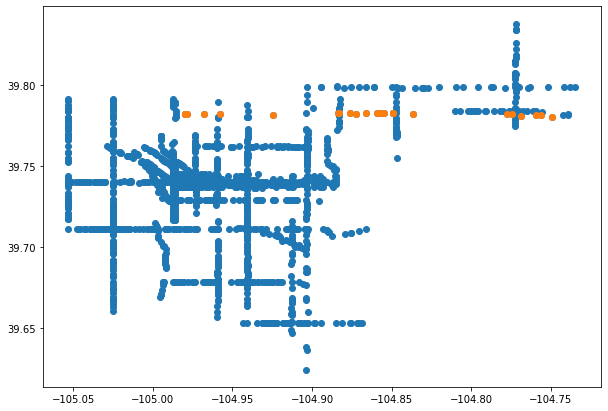

In [44]:
fig, ax = plt.subplots(figsize=(10,7))

data_to_plot = crashes_on_main_streets[crashes_streets.FULLNAME == 'E 47TH AVE'].copy()

plt.scatter(x=crashes_on_main_streets.geo_lon, y=crashes_on_main_streets.geo_lat)
_ = plt.scatter(x=data_to_plot.geo_lon, y=data_to_plot.geo_lat)

In [41]:
# todo: handle discontinuous streets like E 47th Ave